In [4]:
# we import Libraries 
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import pickle


###  Specify Audio Data Directory

Begin by providing the directory path that contains your `.wav` audio files.  
Every file in this directory will be automatically scanned to extract features and associate them with corresponding emotion labels for training or testing.


In [5]:
#   We Define Emotion Labels
data_path= 'Audio_song_speech' 
emotions = {
    1: 'calm', 2: 'happy', 3: 'sad',
    4: 'angry', 5: 'fearful', 6: 'disgust',
    7: 'surprise', 8: 'neutral'
}

#### Define Emotion Labels
We define a dictionary that maps emotion IDs from the filenames to meaningful emotion labels.  
This mapping helps us correctly classify each audio file based on its emotion ID.


####  Check for Missing Data
We check the dataset for any missing or null values to ensure data quality before proceeding to feature extraction and model training.


In [6]:
 def extract_data_from_name(fname):
    parts = fname.split('.')[0].split('-')
    return {
        'filename': fname,
        'modality': int(parts[0]),
        'channel': int(parts[1]),  # 1 = speech, 2 = song
        'emotion_id': int(parts[2]),
        'emotion': emotions.get(int(parts[2]), 'unknown'),
        'intensity': int(parts[3]),
        'statement': int(parts[4]),
        'repeat': int(parts[5]),
        'actor': int(parts[6]),
        'gender': 'male' if int(parts[6]) % 2 != 0 else 'female'
    }

In [7]:
def create_dataframe(link):
    data = []
    for root, dirs, files in os.walk(link):
        for file in files:
            if file.endswith(".wav"):
                metadata = extract_data_from_name(file)
                metadata['path'] = os.path.join(root, file)
                data.append(metadata)
    return pd.DataFrame(data)

df = create_dataframe(data_path)
print("Dataset shape:", df.shape)
df.sample(7)


Dataset shape: (2452, 11)


,filename,modality,channel,emotion_id,emotion,intensity,statement,repeat,actor,gender,path
2067,03-01-05-02-02-02-18.wav,3,1,5,fearful,2,2,2,18,female,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
608,03-02-06-01-01-01-14.wav,3,2,6,disgust,1,1,1,14,female,Audio_song_speech\Audio_Song_Actors_01-24\Acto...
761,03-02-03-01-01-02-19.wav,3,2,3,sad,1,1,2,19,male,Audio_song_speech\Audio_Song_Actors_01-24\Acto...
402,03-02-02-01-02-01-10.wav,3,2,2,happy,1,2,1,10,female,Audio_song_speech\Audio_Song_Actors_01-24\Acto...
2177,03-01-04-02-01-02-20.wav,3,1,4,angry,2,1,2,20,female,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
1551,03-01-08-02-02-02-09.wav,3,1,8,neutral,2,2,2,9,male,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
749,03-02-01-01-01-02-19.wav,3,2,1,calm,1,1,2,19,male,Audio_song_speech\Audio_Song_Actors_01-24\Acto...


In [8]:
df[['filename', 'emotion', 'path']].sample(7)

,filename,emotion,path
2234,03-01-04-01-02-01-21.wav,angry,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
1804,03-01-03-01-01-01-14.wav,sad,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
223,03-02-01-01-02-02-06.wav,calm,Audio_song_speech\Audio_Song_Actors_01-24\Acto...
1880,03-01-05-01-01-01-15.wav,fearful,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
12,03-02-03-01-01-01-01.wav,sad,Audio_song_speech\Audio_Song_Actors_01-24\Acto...
2402,03-01-02-02-02-01-24.wav,happy,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
692,03-02-05-02-01-01-16.wav,fearful,Audio_song_speech\Audio_Song_Actors_01-24\Acto...


In [9]:
#  Extract Metadata from Filename
def extract_data_from_name(fname):
    parts = fname.split('.')[0].split('-')
    return {
        'filename': fname,
        'modality': int(parts[0]),
        'channel': int(parts[1]),  # 1 = speech, 2 = song
        'emotion_id': int(parts[2]),
        'emotion': emotions.get(int(parts[2]), 'unknown'),
        'intensity': int(parts[3]),
        'statement': int(parts[4]),
        'repeat': int(parts[5]),
        'actor': int(parts[6]),
        'gender': 'male' if int(parts[6]) % 2 != 0 else 'female'
    }


####   Extract Metadata from Filename
In this step, we create a function to extract key information from each audio filename, such as:
- Emotion ID
- Gender
- Actor
- Channel type

If the emotion ID is not found in our mapping, it is labeled as `unknown`.


In [10]:
#  Create DataFrame from Audio Files
def create_dataframe(link):
    data = []
    for root, dirs, files in os.walk(link):
        for file in files:
            if file.endswith(".wav"):
                metadata = extract_data_from_name(file)
                metadata['path'] = os.path.join(root, file)
                data.append(metadata)
    return pd.DataFrame(data)

df = create_dataframe(data_path)

print("Dataset shape:", df.shape)
df.sample(5)


Dataset shape: (2452, 11)


,filename,modality,channel,emotion_id,emotion,intensity,statement,repeat,actor,gender,path
1614,03-01-01-01-02-01-11.wav,3,1,1,calm,1,2,1,11,male,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
36,03-02-06-01-01-01-01.wav,3,2,6,disgust,1,1,1,1,male,Audio_song_speech\Audio_Song_Actors_01-24\Acto...
878,03-02-06-02-02-01-21.wav,3,2,6,disgust,2,2,1,21,male,Audio_song_speech\Audio_Song_Actors_01-24\Acto...
1912,03-01-01-01-01-01-16.wav,3,1,1,calm,1,1,1,16,female,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...
2444,03-01-08-01-01-01-24.wav,3,1,8,neutral,1,1,1,24,female,Audio_song_speech\Audio_Speech_Actors_01-24\Ac...


####   Create DataFrame from Audio Files
This part walks through all the audio files in the dataset folder, extracts their metadata using the previous function, and compiles the results into a structured pandas DataFrame for further processing.


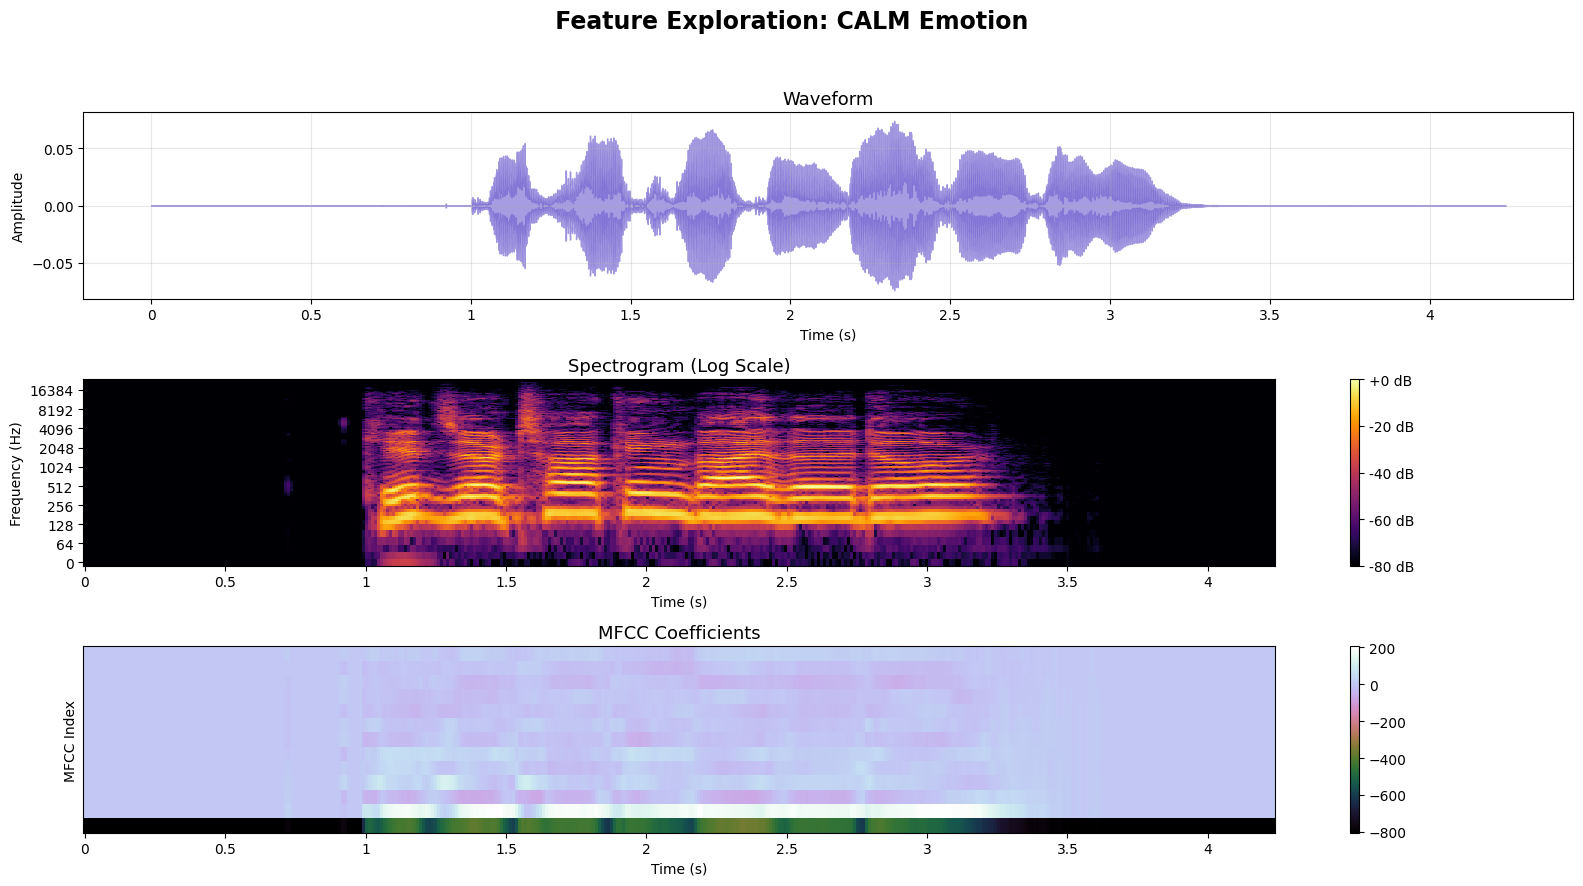

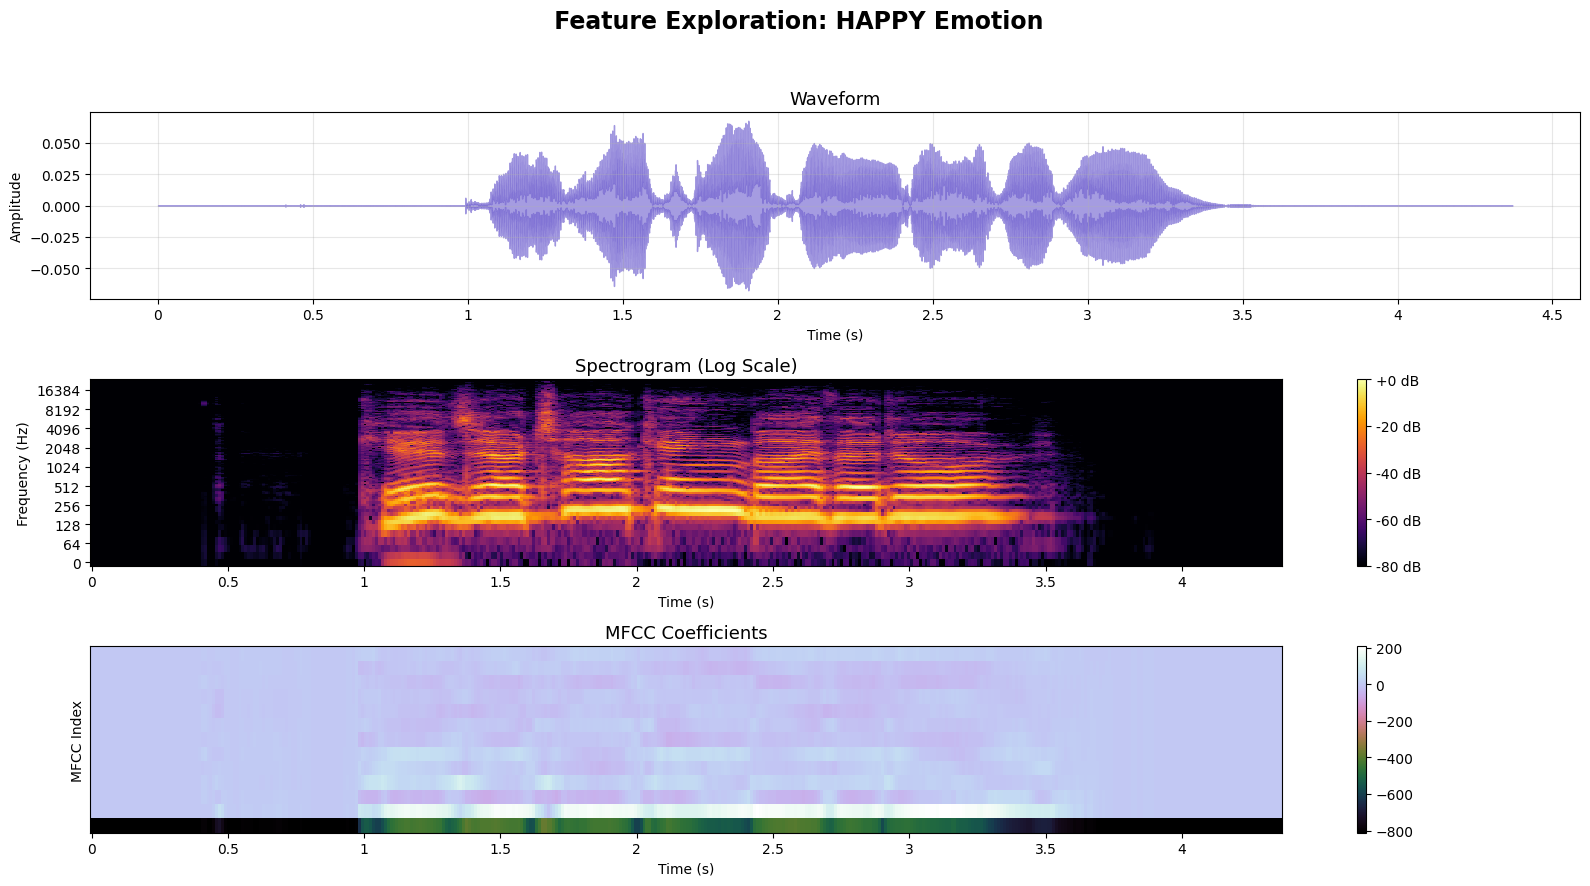

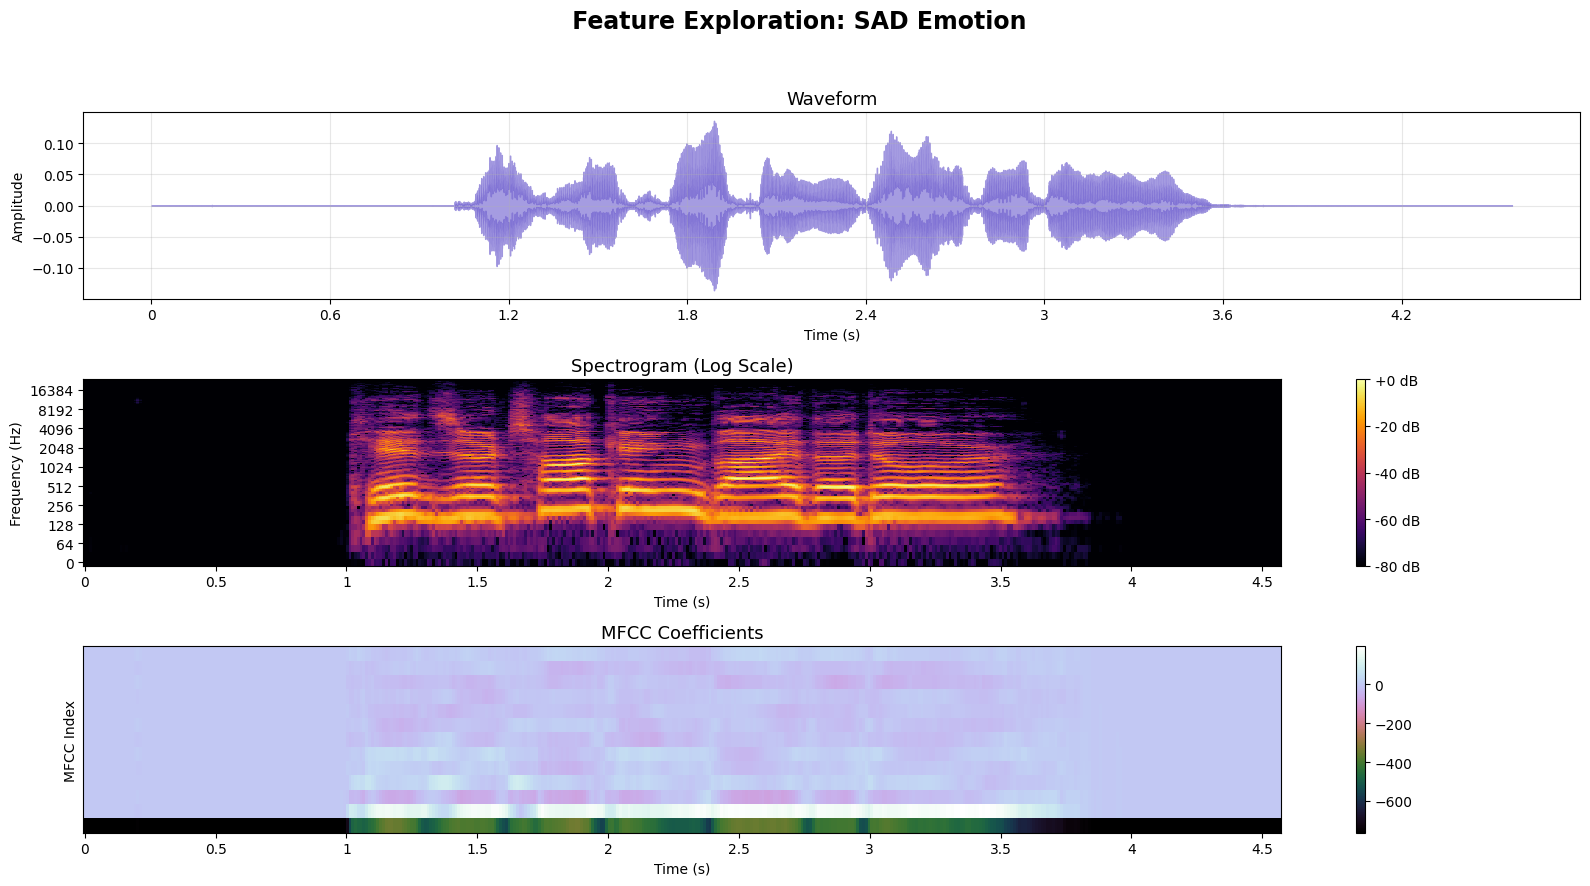

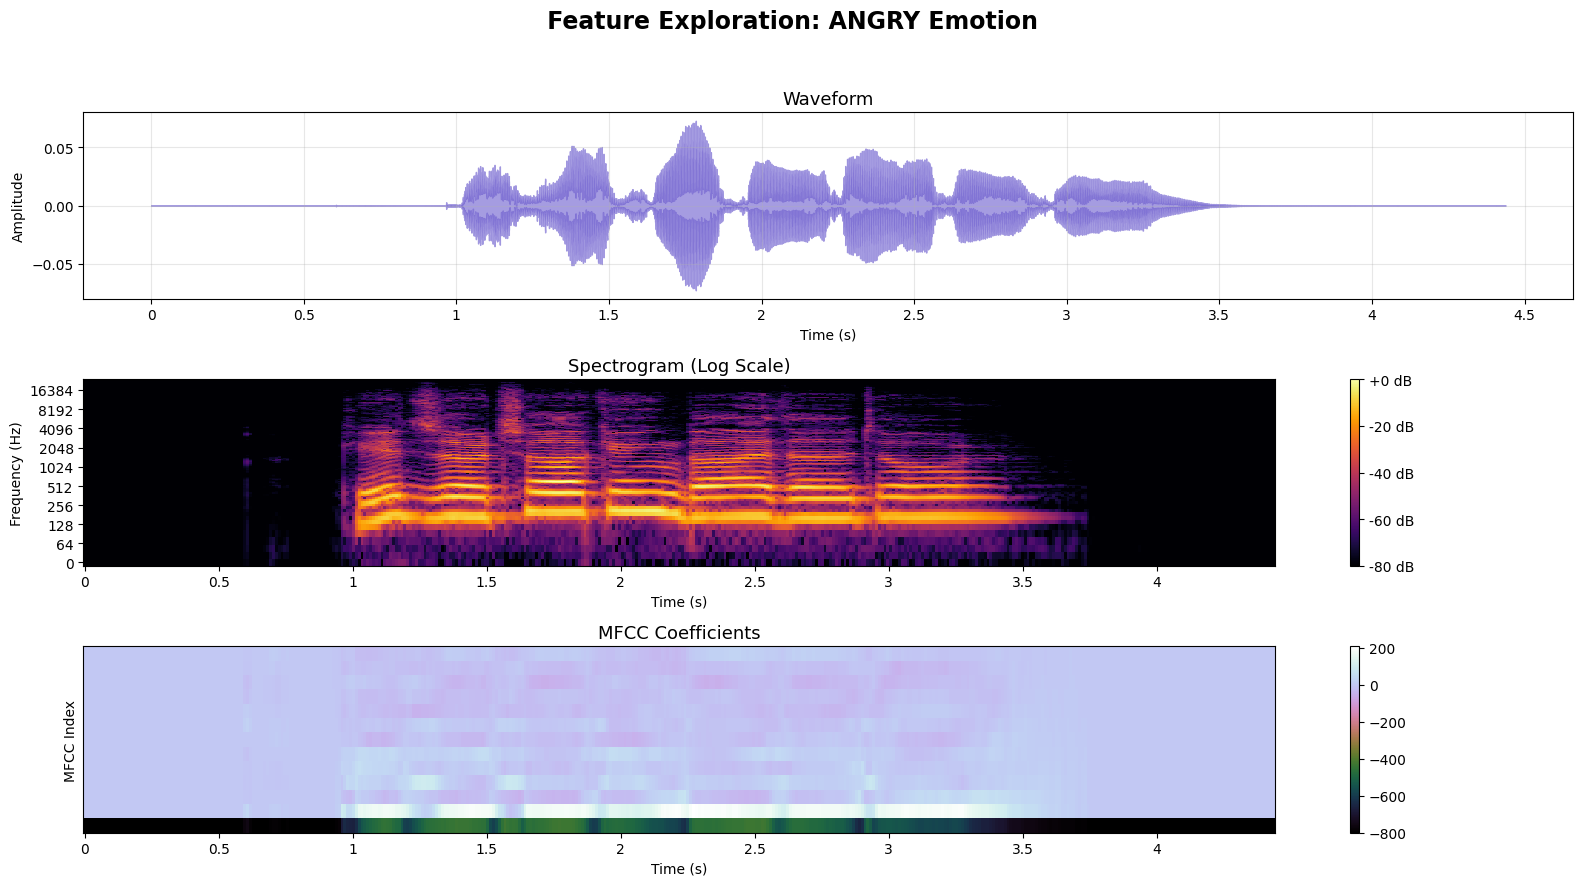

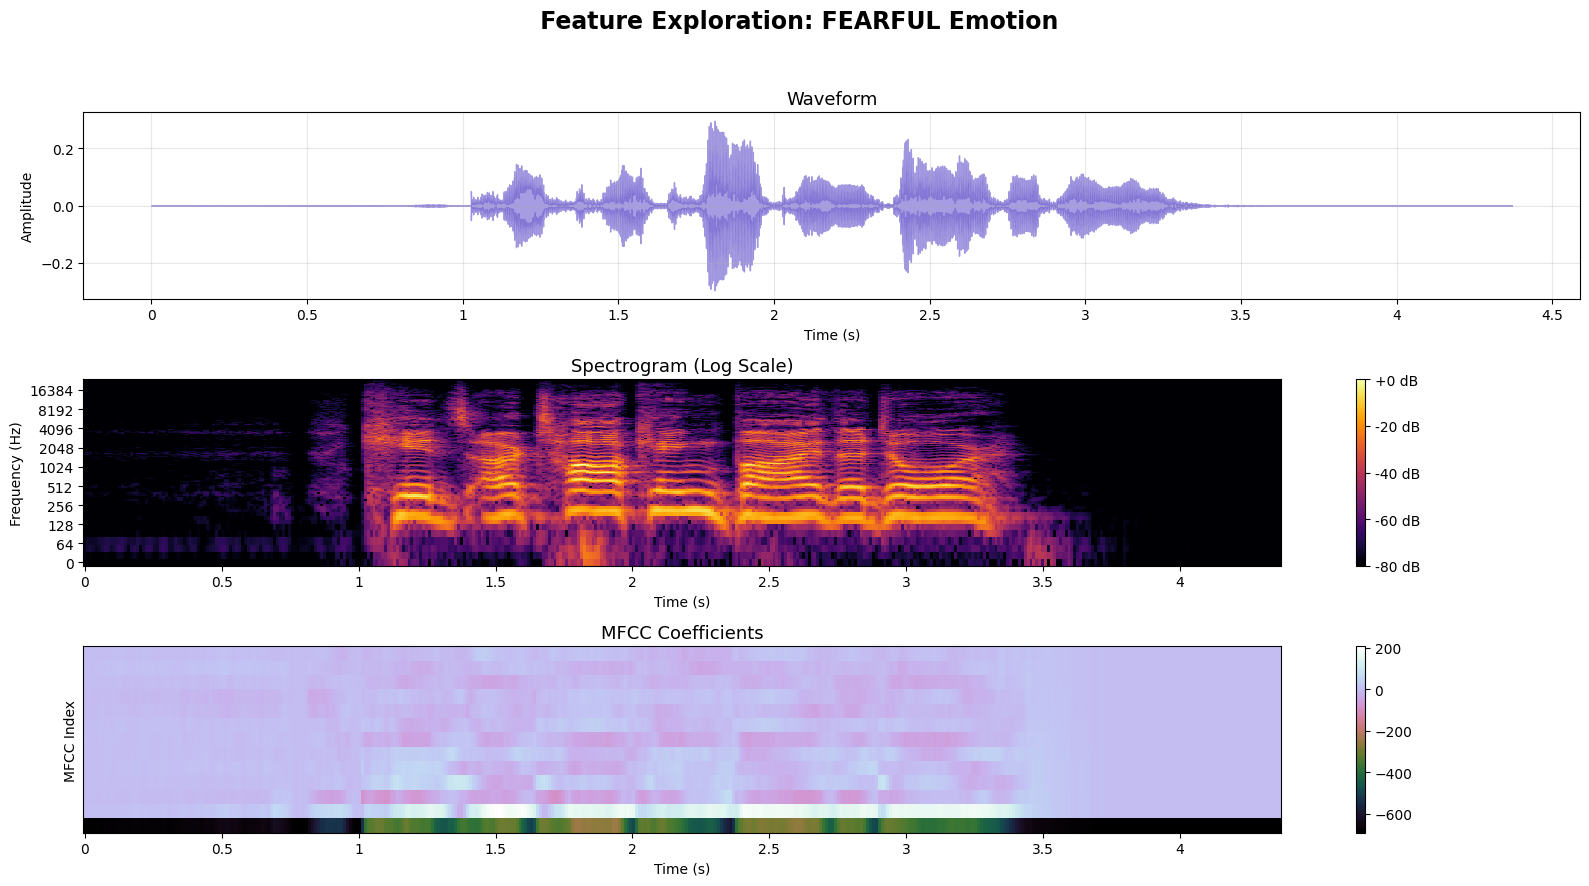

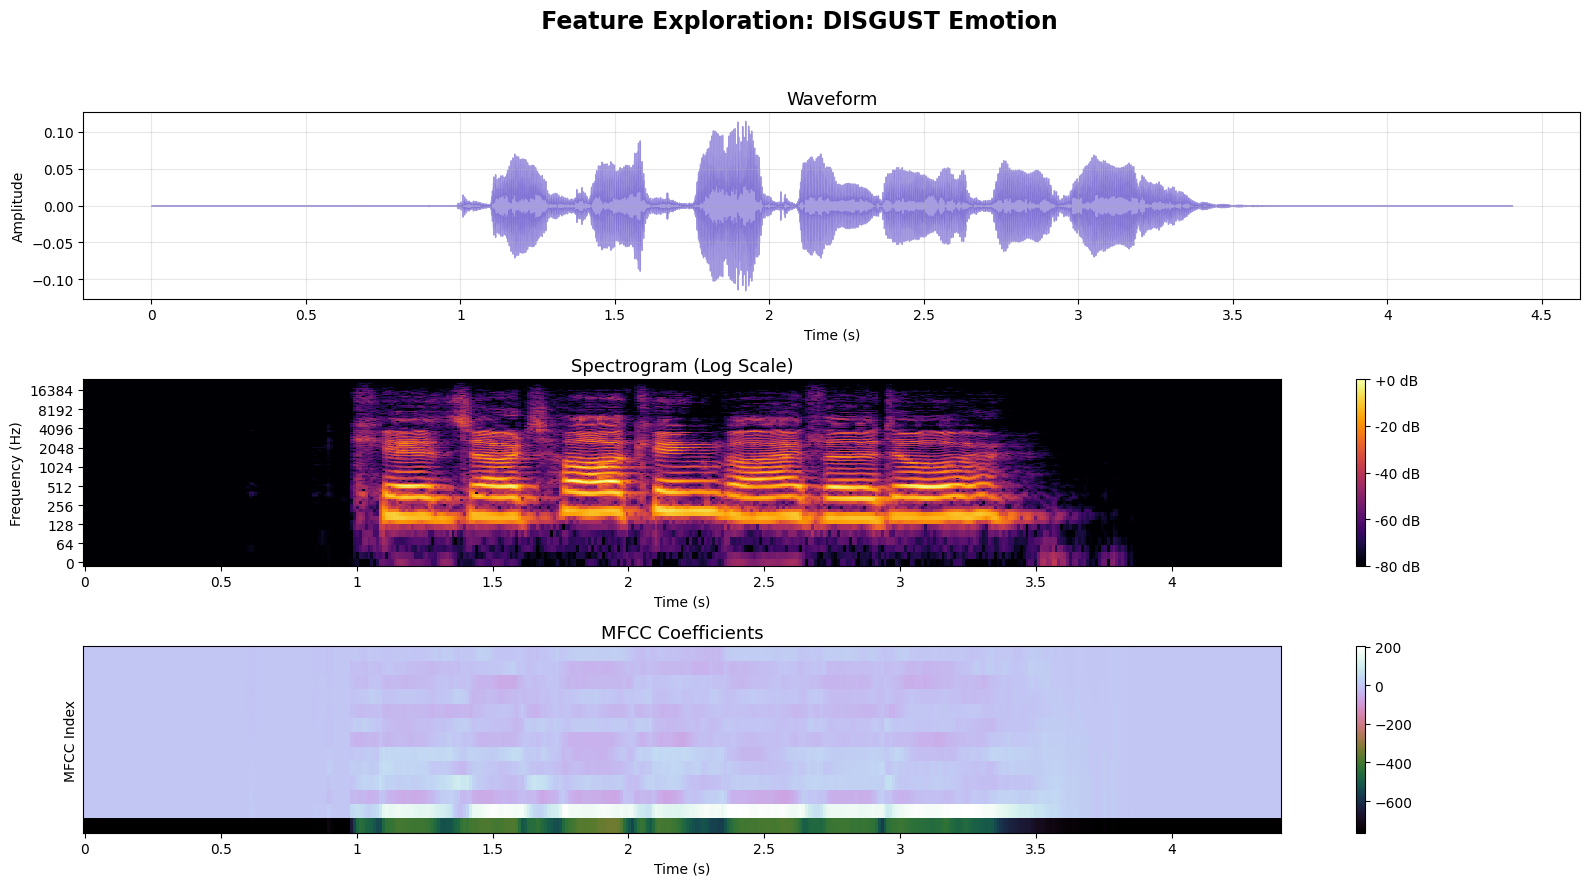

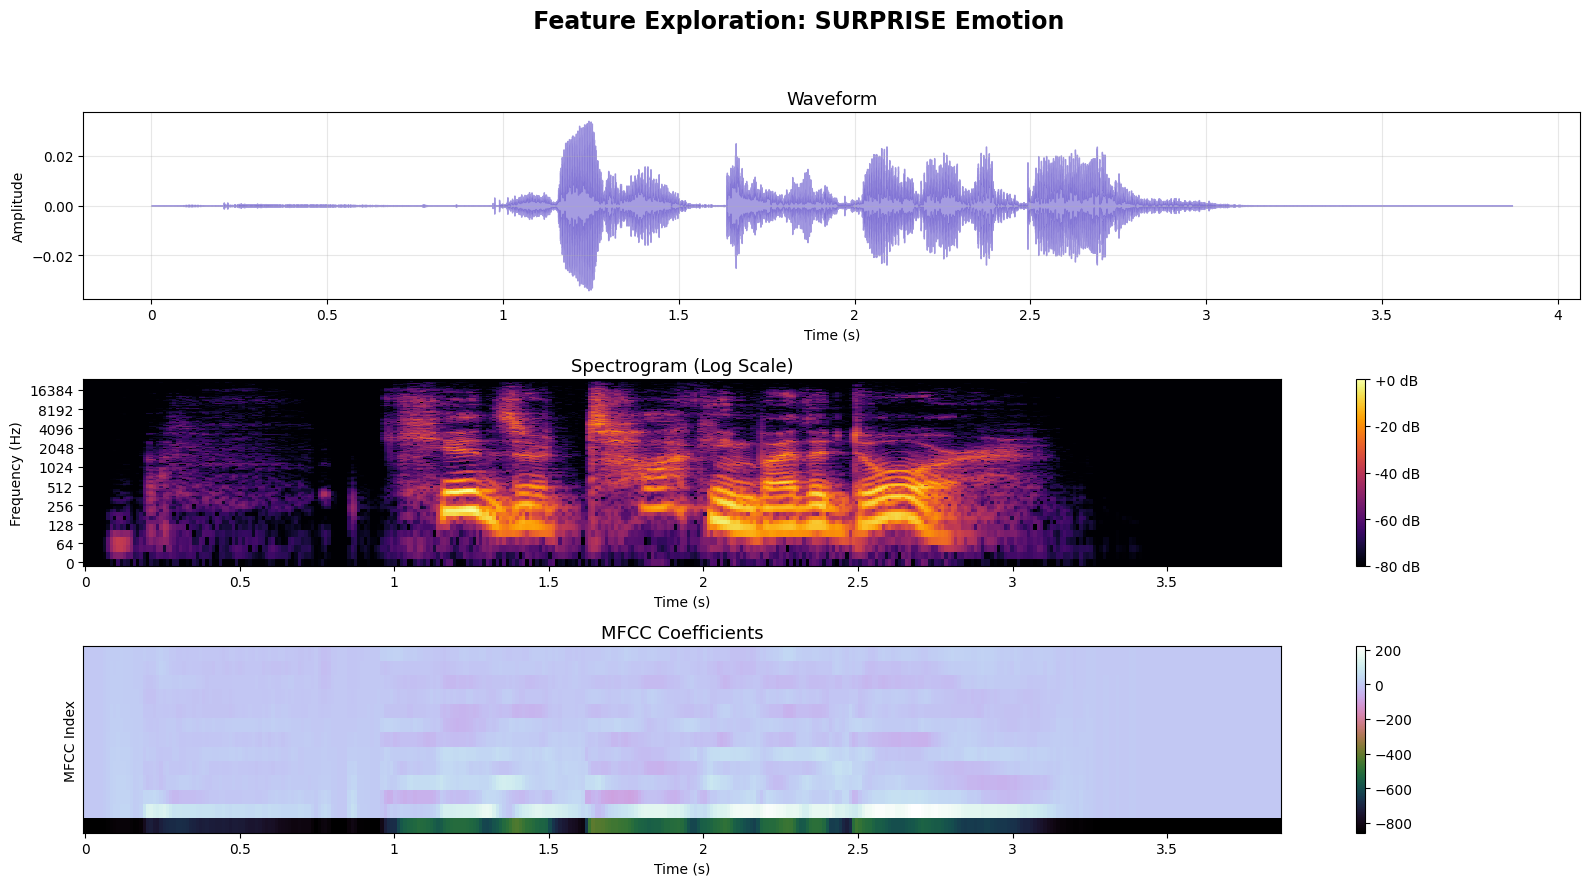

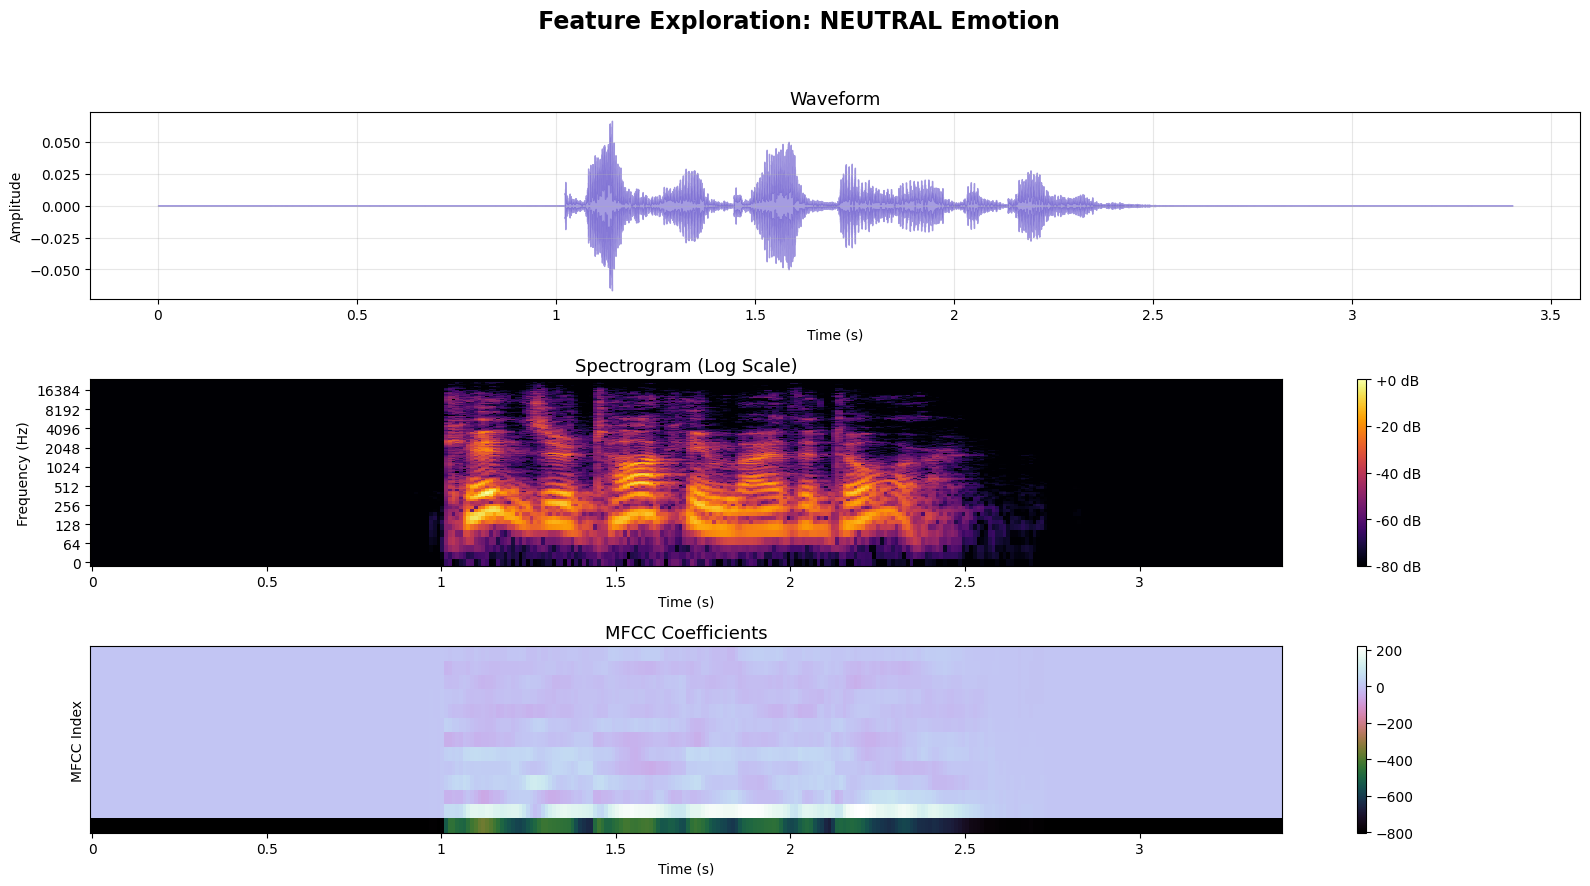

In [13]:
# Enhanced Visualization - Waveform, Spectrogram, MFCC

import librosa.display

# Loop through all distinct emotions
for label in df['emotion'].unique():
    emotion_audio = df[df['emotion'] == label]

    if not emotion_audio.empty:
        audio_sample = emotion_audio.iloc[0]
        signal, sr = librosa.load(audio_sample['path'], sr=None)

        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 9))
        fig.suptitle(f" Feature Exploration: {label.upper()} Emotion", fontsize=17, fontweight='bold')

        # --- 1. Waveform Plot ---
        axes[0].set_title("Waveform", fontsize=13)
        librosa.display.waveshow(signal, sr=sr, ax=axes[0], color="slateblue", alpha=0.6)
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Amplitude")
        axes[0].grid(alpha=0.3)

        # --- 2. Spectrogram ---
        spectrogram = librosa.stft(signal)
        db_spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
        img1 = librosa.display.specshow(db_spectrogram, sr=sr, x_axis="time", y_axis="log", cmap="inferno", ax=axes[1])
        axes[1].set_title("Spectrogram (Log Scale)", fontsize=13)
        axes[1].set_xlabel("Time (s)")
        axes[1].set_ylabel("Frequency (Hz)")
        fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

        # --- 3. MFCC Plot ---
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
        img2 = librosa.display.specshow(mfcc, x_axis="time", sr=sr, cmap="cubehelix", ax=axes[2])
        axes[2].set_title("MFCC Coefficients", fontsize=13)
        axes[2].set_xlabel("Time (s)")
        axes[2].set_ylabel("MFCC Index")
        fig.colorbar(img2, ax=axes[2])

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


#### Enhanced Visualization - Waveform, Spectrogram, MFCC
We visualize the audio signals in three ways for each emotion:
1. **Waveform:** The raw amplitude of the audio over time.
2. **Spectrogram:** Frequency distribution over time in decibels.
3. **MFCC (Mel-frequency cepstral coefficients):** Key features commonly used in audio and speech processing.

This gives a deeper understanding of how different emotions sound and how they vary in frequency.


In [13]:
# Feature Extraction - MFCC
def extract_mfcc_features(wav_path, n_mfcc=40):
    y, sr = librosa.load(wav_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

df['mfcc'] = df['path'].apply(extract_mfcc_features)

# Prepare Data for Model
X = np.stack(df['mfcc'].values)
le = LabelEncoder()
y = le.fit_transform(df['emotion'].values)


####  Feature Extraction - MFCC
We extract MFCC features from each audio file.  
MFCCs capture important characteristics of the audio that are useful for emotion recognition tasks.

The extracted features are stored as numerical vectors for machine learning input.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####   Train-Test Split
We split the dataset into training and testing sets using an 80-20 split.
- Training Set: Used to train the model.
- Test Set: Used to evaluate the model's performance on unseen data.


In [ ]:
# Build XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=400,
    max_depth=6,
    learning_rate=0.07,
    subsample=0.8,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)


####   Build XGBoost Model
We initialize the XGBoost classifier with specific hyperparameters such as:
- Number of trees (n_estimators)
- Learning rate
- Maximum tree depth
- Regularization parameters

XGBoost is chosen for its efficiency and strong performance on classification problems.


In [ ]:
# Part 11: Train Model
xgb_model.fit(X_train, y_train)


####   Train Model
We fit the XGBoost classifier on the training data to learn the patterns that map audio features to their corresponding emotions.


In [ ]:
# Part 12: Evaluate Model
y_pred = xgb_model.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("Original Results (Before Dropping Any Class):")
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Reds", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### Evaluate Model Without droping any class 
We predict the emotions on the test set and calculate:
- Accuracy
- Precision, Recall, F1-Score (Classification Report)
- Confusion Matrix

The confusion matrix helps visualize the model's performance across different emotion classes.


In [ ]:
 
low_precision_classes = ['surprise', 'neutral']


df_filtered = df[~df['emotion'].isin(low_precision_classes)]

# Prepare New Dataset
X_filtered = np.stack(df_filtered['mfcc'].values)
y_filtered = le.fit_transform(df_filtered['emotion'].values)

# Train-Test Split Again
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# WE Retrain Model after dropping 
xgb_model.fit(X_train_f, y_train_f)

# Evaluate Again
y_pred_f = xgb_model.predict(X_test_f)
y_test_f_labels = le.inverse_transform(y_test_f)
y_pred_f_labels = le.inverse_transform(y_pred_f)

print("\nResults After Dropping surprise and neutral classes:")
accuracy_f = accuracy_score(y_test_f_labels, y_pred_f_labels)
print("Accuracy:", accuracy_f)
print("\nClassification Report:\n", classification_report(y_test_f_labels, y_pred_f_labels))

# Confusion Matrix
cm_f = confusion_matrix(y_test_f_labels, y_pred_f_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_f, annot=True, cmap="YlGnBu", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix After Dropping Classes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Dropping Low-Precision Classes: 'surprise' and 'neutral'

In this step, we intentionally remove the `surprise` and `neutral` classes from the dataset because:

1. **Low Precision Issue:**
   - These classes often show significantly lower precision, recall, and f1-scores in the classification report.
   - A low precision means the model frequently misclassifies other emotions as `surprise` or `neutral`.

2. **Class Confusion:**
   - Emotions like `surprise` and `neutral` can have acoustic features that overlap with other emotions.
   - This causes the model to misinterpret these emotions, leading to confusion in the decision boundary.

3. **Improved Model Performance:**
   - By removing these challenging classes, the model can better focus on classifying the remaining emotions more accurately.
   - It often leads to an increase in overall accuracy and better precision/recall balance for the remaining classes.

---

###  Code Breakdown:
- **Filtering Dataset:**
  ```python
  low_precision_classes = ['surprise', 'neutral']
  df_filtered = df[~df['emotion'].isin(low_precision_classes)]


In [ ]:
# Save Model
with open("xgb_model_audio.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

with open("label_encoder_audio.pkl", "wb") as f:
    pickle.dump(le, f)


#### Save Model
We save the trained XGBoost model and the Label Encoder using Python's `pickle` library.
This allows us to reuse the trained model later without retraining it.
